In [1]:
import numpy
numpy.seterr(divide='warn')
import pandas
from tkinter import Tk
from tkinter.filedialog import askdirectory
import seaborn
import matplotlib.pyplot as plt
from vqf import VQF, offlineVQF, pyvqf
import math
from skinematics import view
import qmt

In [2]:
# Get directories for IMU data
forearmPath = askdirectory(title='Select Folder Containing Forearm Data') # shows dialog box and return the path
print(forearmPath)
armPath = forearmPath#askdirectory(title='Select Folder Containing Arm Data') # shows dialog box and return the path
print(armPath)
foreArmGData = pandas.read_csv("{}/Gyroscope.csv".format(forearmPath))
armGData = pandas.read_csv("{}/Gyroscope.csv".format(armPath))
foreArmAData = pandas.read_csv("{}/Accelerometer.csv".format(forearmPath))
armAData = pandas.read_csv("{}/Accelerometer.csv".format(armPath))
foreArmMData = pandas.read_csv("{}/Magnetometer.csv".format(forearmPath))
armMData = pandas.read_csv("{}/Magnetometer.csv".format(armPath))

# Truncate data to have same number of samples
# minDataLength = min([len(armGData), len(foreArmGData), len(armAData), len(foreArmAData), len(armMData), len(foreArmMData)])
# foreArmGData = foreArmGData[:minDataLength]
# armGData = armGData[:minDataLength]
# foreArmAData = foreArmAData[:minDataLength]
# armAData = armAData[:minDataLength]
# foreArmMData = foreArmMData[:minDataLength]
# armMData = armMData[:minDataLength]

print("Times: {}, {}, {}, {}, {}, {}", max(foreArmGData['Time (s)'].values), max(armGData['Time (s)'].values), \
                max(foreArmAData['Time (s)'].values), max(armAData['Time (s)'].values), \
                max(foreArmMData['Time (s)'].values), max(armMData['Time (s)'].values))
minTime = min([ max(foreArmGData['Time (s)'].values), max(armGData['Time (s)'].values), \
                max(foreArmAData['Time (s)'].values), max(armAData['Time (s)'].values), \
                max(foreArmMData['Time (s)'].values), max(armMData['Time (s)'].values)])

# Analyze the time vectors of each sensor and come up with a best guess for the sample rate
# Assume whole number Hz and all sensors sampling at the same rate
foreGSampleInter = numpy.median(numpy.diff(foreArmGData['Time (s)'].values[:]))
armGSampleInter = numpy.median(numpy.diff(armGData['Time (s)'].values[:]))

foreASampleInter = numpy.median(numpy.diff(foreArmAData['Time (s)'].values[:]))
armASampleInter = numpy.median(numpy.diff(armAData['Time (s)'].values[:]))

foreMSampleInter = numpy.median(numpy.diff(foreArmMData['Time (s)'].values[:]))
armMSampleInter = numpy.median(numpy.diff(armMData['Time (s)'].values[:]))

# Initialize gyroscope data array(g1, g2) (2 arrays with # rows equal to # sample and each row [x, y, z])
gDataRaw = numpy.array([numpy.stack([foreArmGData['X (rad/s)'].values, foreArmGData['Y (rad/s)'].values, foreArmGData['Z (rad/s)'].values], 1),\
                    numpy.stack([armGData['X (rad/s)'].values, armGData['Y (rad/s)'].values, armGData['Z (rad/s)'].values], 1)])
gFore = gDataRaw[0]
gArm = gDataRaw[1]

# Initialize accelerometer data array (a1, a1) (2 arrays with # rows equal to # samples and each row [x, y, z])
aDataRaw = numpy.array([numpy.stack([foreArmAData['X (m/s^2)'].values, foreArmAData['Y (m/s^2)'].values, foreArmAData['Z (m/s^2)'].values], 1),\
                    numpy.stack([armAData['X (m/s^2)'].values, armAData['Y (m/s^2)'].values, armAData['Z (m/s^2)'].values], 1)])
aFore = aDataRaw[0]
aArm = aDataRaw[1]

# Initialize magnetometer data array (m1, m1) (2 arrays with # rows equal to # samples and each row [x, y, z])
mDataRaw = numpy.array([numpy.stack([foreArmMData['X (µT)'].values, foreArmMData['Y (µT)'].values, foreArmMData['Z (µT)'].values], 1),\
                    numpy.stack([armMData['X (µT)'].values, armMData['Y (µT)'].values, armMData['Z (µT)'].values], 1)])
mFore = mDataRaw[0]
mArm = mDataRaw[1]

2022-12-07 15:17:00.382 Python[67870:7063073] +[CATransaction synchronize] called within transaction


/Users/alex/Library/Mobile Documents/com~apple~CloudDocs/School/Masters/BME_207/Term Project/20221202_Initial_Full_Data_Run/20221202_FullDataIMU All Data 60hz 2022-12-02 15-13-54
/Users/alex/Library/Mobile Documents/com~apple~CloudDocs/School/Masters/BME_207/Term Project/20221202_Initial_Full_Data_Run/20221202_FullDataIMU All Data 60hz 2022-12-02 15-13-54
Times: {}, {}, {}, {}, {}, {} 401.0955392 401.0955392 401.1043292 401.1043292 401.0955392 401.0955392


In [3]:
# Perform linear interpolation to get evenly sampled data points
# Find the maximum interval between samples to get a resampling rate that is slower than any of the data
maxSampInt = numpy.amax([foreGSampleInter, armGSampleInter, foreASampleInter, armASampleInter, foreMSampleInter, armMSampleInter])
reSampleRate = (numpy.floor(maxSampInt * 1000)+1)/1000
# Find the minimum interval between samples and calculate the minimum duration of sampling to get a time for the new time vector
timeVec = numpy.arange(0, minTime, reSampleRate)
gForeI = []
aForeI = []
mForeI = []
gArmI = []
aArmI = []
mArmI = []
for i in range(0,3):
    gForeI.append(numpy.interp(timeVec, foreArmGData['Time (s)'].values[:], gFore[:, i]))
    aForeI.append(numpy.interp(timeVec, foreArmAData['Time (s)'].values[:], aFore[:, i]))
    mForeI.append(numpy.interp(timeVec, foreArmMData['Time (s)'].values[:], mFore[:, i]))
    gArmI.append(numpy.interp(timeVec, armGData['Time (s)'].values[:], gArm[:, i]))
    aArmI.append(numpy.interp(timeVec, armAData['Time (s)'].values[:], aArm[:, i]))
    mArmI.append(numpy.interp(timeVec, armMData['Time (s)'].values[:], mArm[:, i]))
gForeI = numpy.array(gForeI).T
aForeI = numpy.array(aForeI).T
mForeI = numpy.array(mForeI).T
gArmI = numpy.array(gArmI).T
aArmI = numpy.array(aArmI).T
mArmI = numpy.array(mArmI).T

In [4]:
# Use cross correlation to align data between two phone sensors
corr = numpy.correlate(aArmI[:,1] - numpy.mean(aArmI[:,1]), aForeI[:,1] - numpy.mean(aForeI[:,1]), mode='full')
lag = corr.argmax() - (len(gArmI[:,0]) - 1)
if lag != 0:
    gArm = gArmI[lag:]
    gFore = gForeI[:-lag]
    aArm = aArmI[lag:]
    aFore = aForeI[:-lag]
    mArm = mArmI[lag:]
    mFore = mForeI[:-lag]
    timeVec = timeVec[:-lag]
else:
    gArm = gArmI
    gFore = gForeI
    aArm = aArmI
    aFore = aForeI
    mArm = mArmI
    mFore = mForeI
    timeVec = timeVec

gData = numpy.array([numpy.array(gFore[:]), numpy.array(gArm[:])])
aData = numpy.array([numpy.array(aFore[:]), numpy.array(aArm[:])])
mData = numpy.array([numpy.array(mFore[:]), numpy.array(mArm[:])])

In [5]:
# Using VQF algorithm to get orientation quaternions
# # Only use 6D orientation (no magnetometer, it causes errors)
# Use offline algorithm because we have the whole data set
vqfOffline1 = offlineVQF(gData[0], aData[0], mData[0], reSampleRate)
vqfOffline2 = offlineVQF(gData[1], aData[1], mData[1], reSampleRate)
# Options to play with other algorithms
# vqfOffline1['quat6D'] = qmt.oriEstMahony(gData[1], aData[1], params = {"Ts" : reSampleRate})
# vqfOffline2['quat6D'] = qmt.oriEstMahony(gData[1], aData[1], params = {"Ts" : reSampleRate})

# plot the quaternion of the arm sensor
quatStep = []
jointAngleQuatCos = []
jointAngleQuatSin = []
jointAngleQuatEuler = []
jointAngleQuatSinRel = []
quatNormStart1 = []
quatNormStart2 = []
quatNormRel = []
for i in range(len(vqfOffline2['quat6D'])):
    # Get the angle between the two sensors by mutiplying the inverse quaternion of the arm by the quaternion 
    # of the forearm. Because they are unit quaternions,the inverse is just the conjugate
    quatNormStart1.append(VQF.quatMultiply(VQF.quatConj(vqfOffline1['quat6D'][0]), vqfOffline1['quat6D'][i]))
    quatNormStart2.append(VQF.quatMultiply(VQF.quatConj(vqfOffline2['quat6D'][0]), vqfOffline2['quat6D'][i]))
    quatNormRel.append(VQF.quatMultiply(VQF.quatConj(quatNormStart2[i]), quatNormStart1[i]))
    jointAngleQuatCos.append(2*numpy.rad2deg(numpy.arccos(numpy.dot(quatNormStart1[0], quatNormStart1[i]))))
jointAngleQuatEuler = qmt.eulerAngles(quatNormStart1, axes='zxy')
jointAngleQuatEuler = jointAngleQuatEuler - jointAngleQuatEuler[0]
jointAngleQuatCos = jointAngleQuatCos - jointAngleQuatCos[0]
quatFore= vqfOffline1['quat6D']
quatArm = vqfOffline2['quat6D']

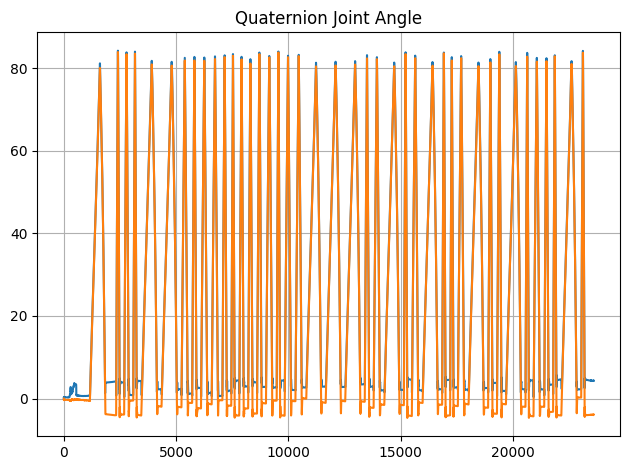

In [6]:
plt.figure()
plt.plot(jointAngleQuatCos)
plt.plot(numpy.rad2deg(jointAngleQuatEuler[:,1]))
plt.title('Quaternion Joint Angle')
plt.grid()
plt.tight_layout()
plt.show()

In [7]:
dataOut = pandas.DataFrame({"Time":timeVec, "IMU Arm Angle":jointAngleQuatCos, "Euler Flexion Angle": numpy.rad2deg(jointAngleQuatEuler[:,1])})
dataOut.to_csv("IMUAngleData.csv")